In [12]:
from qiskit import quantum_info as qi
import numpy as np
import pandas as pd
import scipy.linalg as lng
import random as rnd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.1f}'.format

In [13]:
def I0(L):
    label = ""
    for i in range(0,L):
        label += "I"
    return qi.Operator.from_label(label).data

def X(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Y(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Z(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Z"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data
    
def gx(l,L):
    label = ""
    for i in range(0,l):
        label += "Z"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def gy(l,L):
    label = ""
    for i in range(0,l):
        label += "Z"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def cd(l,L):
    return 1/2*(gx(l,L)+1j*gy(l,L))

def c(l,L):
    return 1/2*(gx(l,L)-1j*gy(l,L))

In [14]:
def bkt(psi_a,U,psi_b):
    return np.dot(np.conjugate(psi_a),np.dot(U,psi_b))

def Mdot(Ol):
    m = Ol[0]
    for i in range(1,len(Ol)):
        m = np.dot(Ol[i],m)
    return m

In [50]:
mu = 0.7

H0 = mu*X(0,1)

In [51]:
print(pd.DataFrame(H0))
e0,y0 = lng.eig(H0)
psi0 = np.conjugate(np.transpose(y0))
print(e0)
psi0[1]

         0        1
0 0.0+0.0j 0.7+0.0j
1 0.7+0.0j 0.0+0.0j
[ 0.7+0.j -0.7+0.j]


array([ 0.70710678-0.j, -0.70710678+0.j])

In [52]:
L0 = int(np.log2(len(H0)))

Hb =-1/2*Z(0,L0+2)

def Hx(cx):
    return cx*(Mdot([X(0,L0+2),X(1,L0+2)])) 

def HR(w):
    w0 = w+1
    L = L0+1
    return (w0*I0(L)+w0*Z(0,L)+np.kron(I0(1),H0)-np.kron(Z(0,1),H0))/2

def H(cx,w):
    return Hb + Hx(cx) + np.kron(I0(1),HR(w))
    

## Using the full exponential

In [53]:
def U(cx,w,t):
    e,psi_d = lng.eig(H(cx,w))
    psi = np.conjugate(np.transpose(psi_d))
    eD = np.diag(e)
    exp = np.exp(1j*e*t)
    expD = np.diag(exp)
    return Mdot([psi,expD,psi_d])


In [70]:
#psiA = np.sqrt(0.2)*qi.Statevector.from_label('00-').data ++np.sqrt(0.7)*qi.Statevector.from_label('00+').data
#psiA = psiA/np.sqrt(bkt(psiA,I0(L0+2),psiA))

psiA = qi.Statevector.from_label('000').data

wl = [wi*0.01-1.5 for wi in range(0,300)]

t = 200.0
t=5
cx = 0.01
Ns = 100
pl = []
for w in wl:
    psiS = psiA
    psiS = Mdot([U(cx,w,t),psiS])
    pw = bkt(psiS,Z(0,L0+2),psiS)

    pl.append(pw)

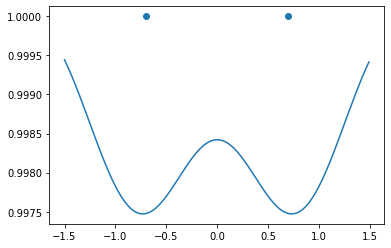

In [71]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()

## Using broken up exponential to match the circuit 

$H = -\frac{1}{2} Z_0 + \epsilon_0 I + \epsilon_0 Z_1 + H_0 - Z_1 H_0 +c_x X_0 X_1$

$H_0 = X_2$

$H = -\frac{1}{2} Z_0 + \frac{1}{2}\epsilon_0 I + \frac{1}{2}\epsilon_0 Z_1 + \frac{1}{2}X_2 - \frac{1}{2}Z_1 X_2 +c_x X_0 X_1$

$U(dt) = e^{i(-\frac{1}{2} Z_0 + \frac{1}{2}\epsilon_0 I + \frac{1}{2}\epsilon_0 Z_1 + \frac{1}{2}X_2 - \frac{1}{2}Z_1 X_2 +c_x X_0 X_1)dt} \approx e^{-i\frac{1}{2}Z_0 dt}e^{i \frac{1}{2}\epsilon_0 dt}e^{i \frac{1}{2}\epsilon_0 Z_1 dt}e^{i\frac{1}{2} X_2 dt}e^{-i\frac{1}{2} Z_1 X_2 dt}e^{c_x X_0 X_1 dt}$

or to second order trotterization

$U(2dt) \approx e^{-i\frac{1}{2}Z_0 dt}e^{i \frac{1}{2}\epsilon_0 dt}e^{i \frac{1}{2}\epsilon_0 Z_1 dt}e^{i\frac{1}{2} X_2 dt}e^{-i\frac{1}{2} Z_1 X_2 dt}e^{c_x X_0 X_1 dt}   e^{c_x X_0 X_1 dt}e^{-i\frac{1}{2} Z_1 X_2 dt}e^{i\frac{1}{2} \epsilon_0 Z_1 dt}e^{i\frac{1}{2} X_2 dt}e^{i\frac{1}{2} \epsilon_0 dt}e^{-i\frac{1}{2}Z_0 dt}$

In [72]:
def UT(cx,w,dt):
    L=L0+2
    w0 = w+1
    Ua = np.cos(-1/2*dt)*I0(L) + 1j*np.sin(-1/2*dt)*Z(0,L)
    Ub = np.cos(1/2*w0*dt)*I0(L) + 1j*np.sin(1/2*w0*dt)*I0(L)
    Uc = np.cos(1/2*w0*dt)*I0(L) + 1j*np.sin(1/2*w0*dt)*Z(1,L)
    Ud = np.cos(1/2*mu*dt)*I0(L) + 1j*np.sin(1/2*mu*dt)*X(2,L)
    Ue = np.cos(-1/2*mu*dt)*I0(L) + 1j*np.sin(-1/2*mu*dt)*Mdot([Z(1,L),X(2,L)])
    Uf = np.cos(cx*dt)*I0(L) + 1j*np.sin(cx*dt)*Mdot([X(0,L),X(1,L)])
    return Mdot([Ua,Ub,Uc,Ud,Ue,Uf,Uf,Ue,Ud,Uc,Ub,Ua])

In [73]:
dt = 0.01
print(np.amax(np.abs(U(0.1,0.5,dt)-I0(3))))
print(np.amax(np.abs(U(0.1,0.5,dt)-UT(0.1,0.5,dt/2))))

0.019999665841244817
2.8082904498539115e-08


In [88]:
#psiA = np.sqrt(0.2)*qi.Statevector.from_label('00-').data ++np.sqrt(0.7)*qi.Statevector.from_label('00+').data
#psiA = psiA/np.sqrt(bkt(psiA,I0(L0+2),psiA))

psiA = qi.Statevector.from_label('000').data

wl = [wi*0.03-1.5 for wi in range(0,100)]

cx = 0.1
#t = np.pi/(2*cx)
t = 5
Ns = 100
dt = 1.0
pl = []
for w in wl:
    psiS = psiA
    for ti in range(0,int(t/dt)):
        psiS = Mdot([UT(cx,w,dt/2),psiS])
    pw = bkt(psiS,Z(0,L0+2),psiS)
    print(w,pw)

    pl.append(pw)

-1.5 (0.9453345489115937+0j)
-1.47 (0.9370961382723878+0j)
-1.44 (0.9284151385217031+0j)
-1.41 (0.9193489524353071+0j)
-1.38 (0.9099607309852336+0j)
-1.35 (0.9003186732030068+0j)
-1.32 (0.8904952485424824+0j)
-1.29 (0.8805663516357369+0j)
-1.26 (0.8706104003673247+0j)
-1.23 (0.8607073890759928+0j)
-1.2 (0.8509379094159223+0j)
-1.17 (0.8413821519604875+0j)
-1.1400000000000001 (0.8321189020015606+0j)
-1.1099999999999999 (0.8232245431807587+0j)
-1.08 (0.81477208258215+0j)
-1.05 (0.8068302107176271+0j)
-1.02 (0.7994624094491422+0j)
-0.99 (0.792726120320184+0j)
-0.96 (0.7866719850197001+0j)
-0.93 (0.7813431687852329+0j)
-0.9 (0.7767747764801074+0j)
-0.87 (0.7729933698666881+0j)
-0.8400000000000001 (0.7700165932605574+0j)
-0.81 (0.7678529133069567+0j)
-0.78 (0.7665014770912548+0j)
-0.75 (0.7659520911999678+0j)
-0.72 (0.7661853227109039+0j)
-0.6900000000000001 (0.767172721432034+0j)
-0.66 (0.7688771610530443+0j)
-0.63 (0.7712532952429659+0j)
-0.6000000000000001 (0.7742481231457323+0j)
-0.5700

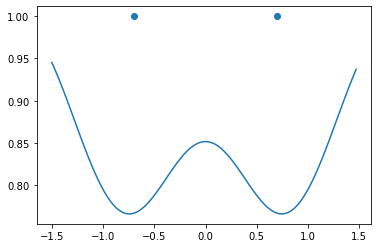

In [89]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()

## Using the gate version of the operators in U

In [90]:
def Rz(phi,l,L):
    return np.cos(phi/2)*I0(L) + 1j*np.sin(phi/2)*Z(l,L)

def Rx(phi,l,L):
    return np.cos(phi/2)*I0(L) + 1j*np.sin(phi/2)*X(l,L)

def Ry(phi,l,L):
    return np.cos(phi/2)*I0(L) + 1j*np.sin(phi/2)*Y(l,L)

def Cx(l,ll,L):
    return 1/2*(I0(L)+Z(l,L)+X(ll,L)-Mdot([Z(l,L),X(ll,L)]))

In [91]:
def UG(cx,w,dt):
    L=L0+2
    w0 = w+1
    Ua = Rz(-dt,0,L)
    Ub = np.exp(1j*1/2*w0*dt)*I0(L)  #A global phase
    Uc = Rz(w0*dt,1,L)
    Ud = Rx(mu*dt,2,L)
    Ue =  Mdot([Ry(-np.pi/2,1,L),Cx(1,2,3),Rx(-mu*dt,1,3),Cx(1,2,3),Ry(np.pi/2,1,L)])
    Uf = Mdot([Cx(0,1,3),Rx(2*cx*dt,0,3),Cx(0,1,3)])

    #return Mdot([Ua,Ub,Uc,Ud,Ue,Uf,Uf,Ue,Ud,Uc,Ub,Ua])
    return Mdot([Ua,Uc,Ud,Ue,Uf,Uf,Ue,Ud,Uc,Ua])

In [92]:
#np.amax(np.abs(UT(cx,w,dt)-UG(cx,w,dt)))

In [95]:
#psiA = np.sqrt(0.2)*qi.Statevector.from_label('00-').data ++np.sqrt(0.7)*qi.Statevector.from_label('00+').data

#Changed the wave function to make it easier to get to
psiA = np.sqrt(0.2)*qi.Statevector.from_label('000').data
psiA = psiA/np.sqrt(bkt(psiA,I0(L0+2),psiA))
wl = [wi*0.03-1.5 for wi in range(0,100)]

cx = 0.1
#t = np.pi/(2*cx)
t = 5
Ns = 100
#dt = 0.1
dt = 1.0
pl = []
for w in wl:
    psiS = psiA
    for ti in range(0,int(t/dt)):
        psiS = Mdot([UG(cx,w,dt/2),psiS])
    pw = bkt(psiS,Z(0,L0+2),psiS)
    print(w,pw)

    pl.append(pw)

-1.5 (0.9453345489115932+0j)
-1.47 (0.9370961382723895+0j)
-1.44 (0.9284151385217061+0j)
-1.41 (0.9193489524353086+0j)
-1.38 (0.9099607309852351+0j)
-1.35 (0.9003186732030095+0j)
-1.32 (0.8904952485424833+0j)
-1.29 (0.8805663516357382+0j)
-1.26 (0.8706104003673277+0j)
-1.23 (0.8607073890759952+0j)
-1.2 (0.8509379094159252+0j)
-1.17 (0.8413821519604903+0j)
-1.1400000000000001 (0.8321189020015618+0j)
-1.1099999999999999 (0.8232245431807601+0j)
-1.08 (0.814772082582152+0j)
-1.05 (0.8068302107176261+0j)
-1.02 (0.799462409449144+0j)
-0.99 (0.7927261203201879+0j)
-0.96 (0.7866719850197048+0j)
-0.93 (0.7813431687852328+0j)
-0.9 (0.7767747764801063+0j)
-0.87 (0.772993369866689+0j)
-0.8400000000000001 (0.7700165932605565+0j)
-0.81 (0.767852913306957+0j)
-0.78 (0.7665014770912542+0j)
-0.75 (0.7659520911999713+0j)
-0.72 (0.7661853227109078+0j)
-0.6900000000000001 (0.7671727214320381+0j)
-0.66 (0.7688771610530457+0j)
-0.63 (0.7712532952429655+0j)
-0.6000000000000001 (0.7742481231457305+0j)
-0.5700

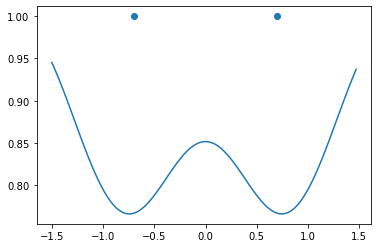

In [96]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()

## Now use the qiskit gates

In [97]:
from qiskit import IBMQ, QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit import Aer

import copy

In [98]:
qr = QuantumRegister(3, name='q')
cr = ClassicalRegister(3, name='c')
qc = QuantumCircuit(qr, cr)

In [99]:
#Reversed the labeling of the qubits

def apply_UQ(cir,cx,w,dt):
    L=L0+2
    w0 = w+1
    
    cir.rz(dt,2)  #Ua
    
    #Ub is a global phase
    
    cir.rz(-w0*dt,1) #Uc
    
    cir.rx(-mu*dt,0) #Ud
    
    cir.ry(np.pi/2,1) #Ue
    cir.cx(1,0)
    cir.rx(mu*dt,1)
    cir.cx(1,0)
    cir.ry(-np.pi/2,1)
    
    cir.cx(2,1)       #Uf
    cir.rx(-2*cx*dt,2)
    cir.cx(2,1)
    
    cir.cx(2,1)       #Uf
    cir.rx(-2*cx*dt,2)
    cir.cx(2,1)
    
    cir.ry(np.pi/2,1) #Ue
    cir.cx(1,0)
    cir.rx(mu*dt,1)
    cir.cx(1,0)
    cir.ry(-np.pi/2,1)
    
    cir.rx(-mu*dt,0) #Ud
    
    cir.rz(-w0*dt,1) #Uc
    
    cir.rz(dt,2)  #Ua
    
    return cir
    


In [100]:
cir = copy.deepcopy(qc)
apply_UQ(cir,w,cx,dt)

#cir.draw()

In [101]:
cir = copy.deepcopy(qc)
apply_UQ(cir,w,cx,dt/2)
psi000 = qi.Statevector.from_label('000').data

np.amax(np.abs(qi.Statevector.from_instruction(cir).data-Mdot([UG(w,cx,dt/2),psi000])))

2.2566322082725374e-16

In [110]:
qr = QuantumRegister(3, name='q')
cr = ClassicalRegister(3, name='c')
qc = QuantumCircuit(qr, cr)


wl = [wi*0.03-1.5 for wi in range(0,100)]

#wl = [0.28,0.98]
cir_l = [] 

cx = 0.1
t = np.pi/(2*cx)
t = 5
Ns = 100
dt = 0.1
dt = 1.0
pl = []
for w in wl:
    print(w)
    cir = copy.deepcopy(qc)
    for ti in range(0,int(t/dt)):
        apply_UQ(cir,cx,w,dt/2)
    cir_l.append(cir)
    
    #cir.measure(0,0)
    #cir.measure(1,1)
    cir.measure(2,2)


-1.5
-1.47
-1.44
-1.41
-1.38
-1.35
-1.32
-1.29
-1.26
-1.23
-1.2
-1.17
-1.1400000000000001
-1.1099999999999999
-1.08
-1.05
-1.02
-0.99
-0.96
-0.93
-0.9
-0.87
-0.8400000000000001
-0.81
-0.78
-0.75
-0.72
-0.6900000000000001
-0.66
-0.63
-0.6000000000000001
-0.5700000000000001
-0.54
-0.51
-0.48
-0.44999999999999996
-0.41999999999999993
-0.3900000000000001
-0.3600000000000001
-0.33000000000000007
-0.30000000000000004
-0.27
-0.24
-0.20999999999999996
-0.18000000000000016
-0.15000000000000013
-0.1200000000000001
-0.09000000000000008
-0.06000000000000005
-0.030000000000000027
0.0
0.030000000000000027
0.06000000000000005
0.08999999999999986
0.11999999999999988
0.1499999999999999
0.17999999999999994
0.20999999999999996
0.24
0.27
0.2999999999999998
0.32999999999999985
0.3599999999999999
0.3899999999999999
0.41999999999999993
0.44999999999999996
0.48
0.5099999999999998
0.54
0.5699999999999998
0.6000000000000001
0.6299999999999999
0.6600000000000001
0.69
0.7199999999999998
0.75
0.7799999999999998
0.

In [111]:
backend = Aer.get_backend("qasm_simulator")

qobj = assemble(transpile(cir_l, backend=backend), backend=backend, shots=2056)

In [112]:
job = backend.run(qobj)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

2acb1b4c-42d3-4c7e-822f-df825a89d30f
Job Status: job has successfully run


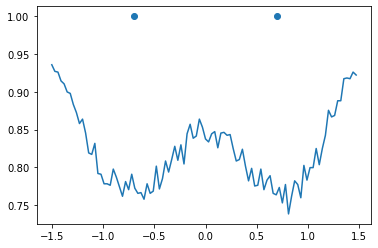

In [113]:
zr = job.result().get_counts()
pz = [(zr[i]['000']-zr[i]['100'])/(zr[i]['000']+zr[i]['100']) for i in range(len(wl))]

marker = [1 for i in e0]

plt.plot(wl,pz)
plt.scatter(e0,marker)
plt.show()

### and on a real device

In [114]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-university', group='uni-pittsburgh', project='main')

ibmqfactory.load_account:WARNING:2021-02-23 10:14:08,861: Credentials are already in use. The existing account in the session will be replaced.


In [115]:
backend = provider.get_backend('ibmq_casablanca')

qobj = assemble(transpile(cir_l, backend=backend), backend=backend, shots=2056)

In [116]:
job = backend.run(qobj)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

60351bcd9550ed4192631cd7
Job Status: job has successfully run


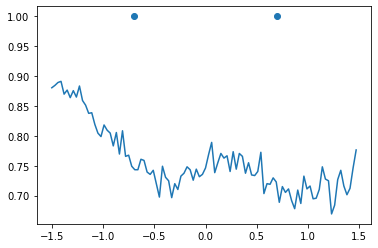

In [117]:
zr = job.result().get_counts()
pz = [(zr[i]['000']-zr[i]['100'])/(zr[i]['000']+zr[i]['100']) for i in range(len(wl))]

marker = [1 for i in e0]

plt.plot(wl,pz)
plt.scatter(e0,marker)
plt.show()

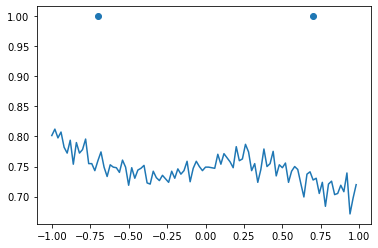

In [109]:
zr = job.result().get_counts()
pz = [(zr[i]['000']-zr[i]['100'])/(zr[i]['000']+zr[i]['100']) for i in range(len(wl))]

marker = [1 for i in e0]

plt.plot(wl,pz)
plt.scatter(e0,marker)
plt.show()

In [1]:
pwd

'C:\\Users\\jsten\\IBMQ\\Measurment_Eigensolver'